# ECG Anomaly Data + Keras 2 Autoencoders 
## Autoencoder: What is it?
In this project, we will compile and apply 2 Keras autoencoders to label ECG data as 'normal' or as having an 'anomaly'. 

**Autoencoder:** 
- unsupervised ML
- special type of neural network (NN) that encodes (compresses) a dim reduced format of the data and then decodes (reconstructs) it back into an image --> want to minimise reconstruction error
    - determines latent variables for most efficient deconstruxn/reconstruxn


## ECG Data Exploration

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Reshape

from sklearn.metrics import precision_recall_curve, auc

In [2]:
# load dataset
fpath = '../Data/ecg.csv'
df = pd.read_csv(fpath, header=None)
print(df.shape)
print(df.head())

(4998, 141)
        0         1         2         3    ...       137       138       139  140
0 -0.112522 -2.827204 -3.773897 -4.349751  ...  0.123431  0.925286  0.193137  1.0
1 -1.100878 -3.996840 -4.285843 -4.506579  ...  0.773820  1.119621 -1.436250  1.0
2 -0.567088 -2.593450 -3.874230 -4.584095  ...  0.321097  0.904227 -0.421797  1.0
3  0.490473 -1.914407 -3.616364 -4.318823  ...  1.086798  1.403011 -0.383564  1.0
4  0.800232 -0.874252 -2.384761 -3.973292  ...  0.971020  1.614392  1.421456  1.0

[5 rows x 141 columns]


In [3]:
# split feature and target data
# last col is target labels; no col names --> use integer indexing
# .iloc(row:row, col:col) 
data = df.iloc[:, 0:-1].values # .values --> ndarray
labels = df.iloc[:, -1].values
print(data.shape, labels.shape)


(4998, 140) (4998,)


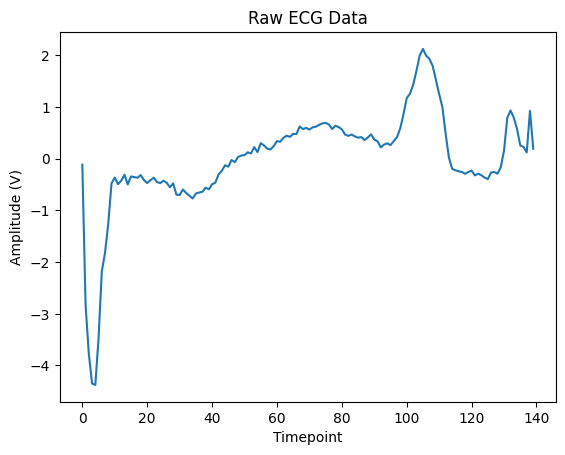

In [4]:
plt.plot(data[0])
plt.title('Raw ECG Data')
plt.xlabel('Timepoint')
plt.ylabel('Amplitude (V)')
plt.show()

Below is a diagram of possible normal ECG waves. The activation peaks have values of 5 or 7, and these peaks can be positive (+) or negative (-). It appears that our data contains the QU phase of a single wave with a negative activation, such as the AS or IL graphs. As we have an identifiable plot, excessive preprocessing is not required. We can start by initially performing normalisation as our preprocessing method of choice. Other filtering steps can be considered if the model does not perform well.

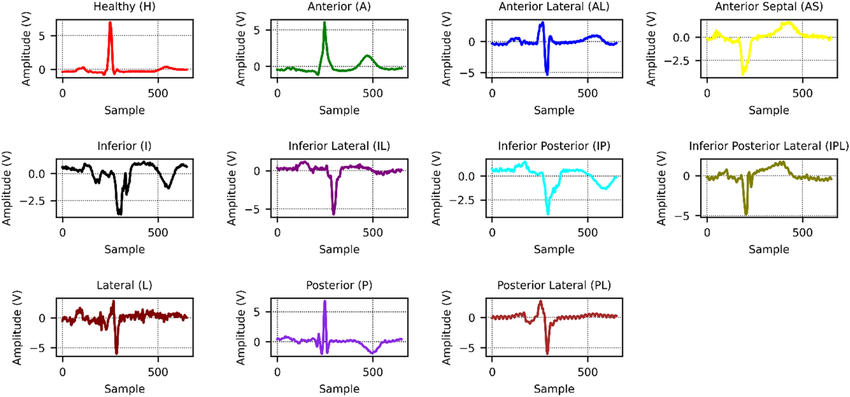 

**Figure 1. Lead III waveforms on example ECG signals of different classes in the dataset.** \
Source: Barua, Prabal Datta, et al. "Multilevel hybrid accurate handcrafted model for myocardial infarction classification using ECG signals." International Journal of Machine Learning and Cybernetics 14.5 (2023): 1651-1668. https://arxiv.org/pdf/2311.04229


<div>
<img src="https://litfl.com/wp-content/uploads/2018/10/ECG-waves-segments-and-intervals-LITFL-ECG-library-3.jpg", width=750/>
</div>

**Figure 2. Model ECG diagram with labels describing wave points.** \
Source: Ed Burns & Robert Buttner. "Q Wave", Life in the Fastlane. https://litfl.com/q-wave-ecg-library/ 

## Data Preprocessing

In [5]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=12)

After splitting, we will normalise the data. 
This 2025 paper by the University of Alberta provides a review of many preprocessing steps for ECG data and their impacts on data interpretability: \
Salimi, Amir, et al. "Exploring best practices for ecg signal processing in machine learning." arXiv preprint arXiv:2311.04229 (2023). https://arxiv.org/pdf/2311.04229

Min-Max normalisation works well for neural networking algorithms. 

In [6]:
# Min-Max normalise
minX = tf.reduce_min(X_train)
maxX = tf.reduce_max(X_train)

# Now apply (data - min)/(max - min)
X_train = (X_train - minX)/(maxX - minX)
X_test = (X_test - minX)/(maxX - minX)


In [7]:

# convert labels to boolean for easier target separation 
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

# normal ECG train + test data
norm_train = X_train[y_train]
norm_test = X_test[y_test]
# abnormal ECG train + test data 
abn_train = X_train[~y_train]
abn_test = X_test[~y_test]

# validation step
len(abn_train) + len(norm_train) == len(X_train)

True

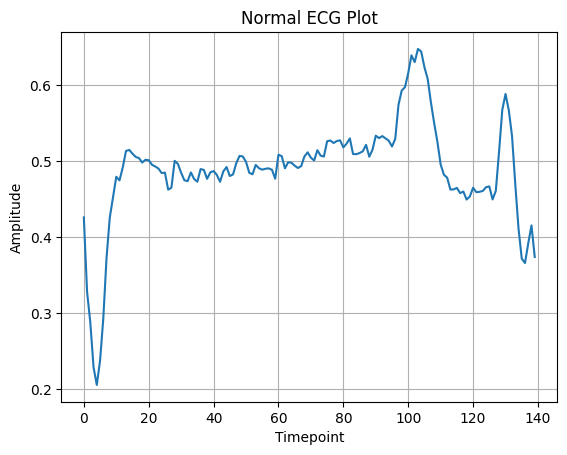

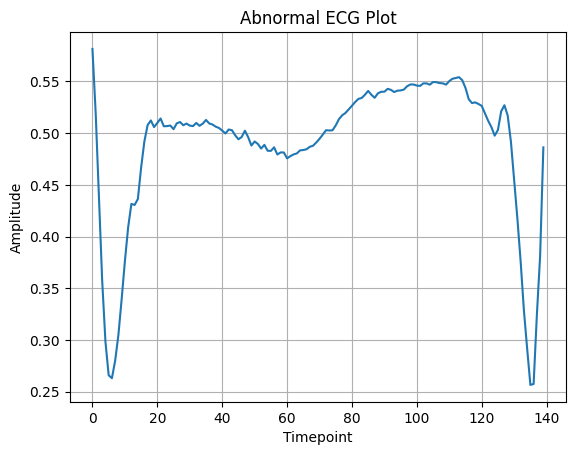

In [8]:
# plot the ECG data
# x = Timepoint, y = ECG Amplitude over 140 Timepointpoints
plt.plot(np.arange(140), norm_train[1]) # select a single subject row
plt.grid()
plt.title('Normal ECG Plot')
plt.xlabel('Timepoint')
plt.ylabel('Amplitude')
# plt.ylim(0,1)
plt.show()

plt.plot(np.arange(140), abn_train[1])
plt.grid()
plt.xlabel('Timepoint')
plt.ylabel('Amplitude')
plt.title('Abnormal ECG Plot')
plt.show()

# **Run Models**

An autoencoder tries to recreate the input after dimension-reduced storage. \
We want the autoencoder to detect anomalies in the data. \
**reconstruction error** = difference between input and decoded output.\
We will train the autoencoder on only normal ECG data, but present both normal and anomalous ECG test data \
--> reconstruction error should be larger for anomolous ECG data since the autoencoder is not trained for this data shape, resulting in poor reconstruction performance.

We will thus set a reconstruction error threshold to determine 'normal' or 'anomaly' label assignment. 

# Keras Functional API Model
Functional NN API; can describe layers using common Keras functions and connect input to output, or input to latency. Often used for autoencoders. 

When evaluating reconstruction performance, we want to compare the reconstruction of the input to the input, so the input and examination are the same data twice (norm_train, norm_train; abn_test, abn_test)

In [9]:
# Keras Functional API model
input_layer = Input(shape=(140, 1))

# encode the data
    # Conv1D convolution, filters = number of features to filter down to
    # must connect to input layer  
x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_layer)
x = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(x)

# flatten + compress 
x = Flatten()(x)   # 2D -> 1D 
latent_layer = Dense(8, activation='relu')(x) # final encoding step

# decode the data; mirrors encoding
# describe all decoding layers 
x = Dense(16, activation='relu')(latent_layer)
x = Dense(32, activation='relu')(x)
decoder_output = Dense(140, activation='sigmoid')(x)  # Match input dimensions; sigmoid gives [0,1] output

# full model instantiation
autoencoder_API = Model(input_layer, decoder_output)
encoder_API = Model(input_layer, latent_layer)

We will now compile the Functional API autoencoder based on normal ECG data only.

In [10]:
# compile + train
autoencoder_API.compile(
    optimizer = 'adam', # standard optimiser 'adaptive learning rate optimizer'
    loss = 'mse') #mse for reconstruction error

tf.experimental.numpy.experimental_enable_numpy_behavior()
norm_train_API = norm_train.reshape(-1, 140, 1)
norm_test_API = norm_test.reshape(-1, 140, 1)

abn_train_API = abn_train.reshape(-1, 140, 1)
abn_test_API = abn_test.reshape(-1, 140, 1)
# verify 
print(norm_train_API.shape, norm_test_API.shape)

(2341, 140, 1) (578, 140, 1)


In [11]:
history_metrics = autoencoder_API.fit(
    norm_train_API, norm_train_API, # check against itself for reconstruction error
    epochs = 30, # iterations
    batch_size=32, # num of samples per gradient update
    validation_data= (norm_test_API, norm_test_API),
    shuffle=True, # randomise traiing order per epoch
    verbose=1
)
# the output of API.fit() is history = loss metrics for each epoch/iteration of the training


Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0023 - val_loss: 9.9672e-04
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0010 - val_loss: 9.6271e-04
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.6960e-04 - val_loss: 9.1171e-04
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.2072e-04 - val_loss: 8.6388e-04
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.2375e-04 - val_loss: 6.8940e-04
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5252e-04 - val_loss: 5.6606e-04
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.6379e-04 - val_loss: 5.0063e-04
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.0956e-04 - val_loss: 4.5981e-04
Epoch 9/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.8072e-04 - val_loss: 4.3982e-04
Epoch 10/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6383e-04 - val_loss: 4.2525e-04
Epoch 11/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5085e-04 - val_loss: 4.19

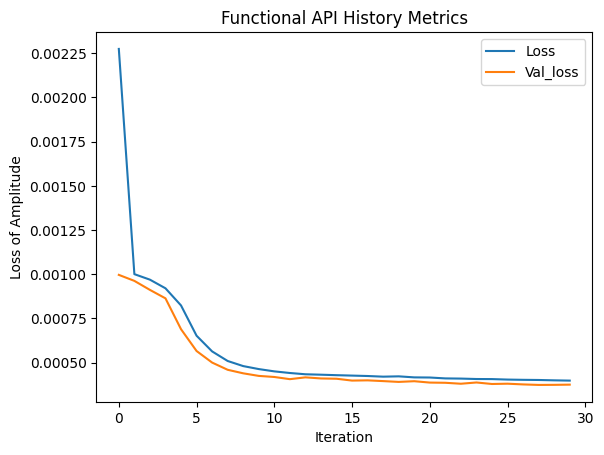

In [12]:
# plot history metrics
plt.plot(history_metrics.history['loss'])
plt.plot(history_metrics.history['val_loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss of Amplitude')
plt.title('Functional API History Metrics')
plt.legend(labels=['Loss', 'Val_loss'])
plt.show()

#### Visualisation

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


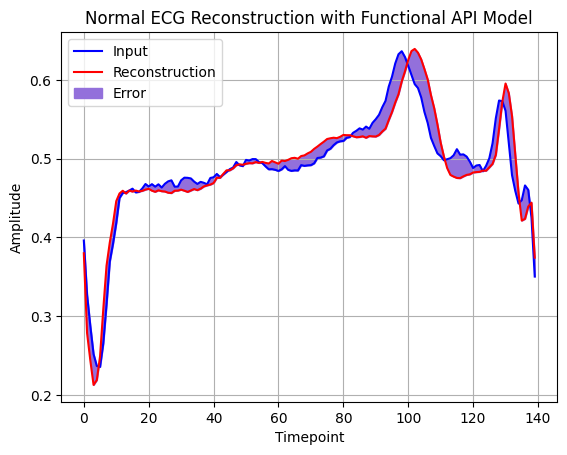

In [13]:

# reconstruction via predict
reconstructed = autoencoder_API.predict(norm_test_API)

def plot(raw_data, n, reconstruction, fig_title):
    # original data in blue line
    plt.plot(raw_data[n].flatten(), 'b') # flatten to vector if not already 
    # decoded image in red line
    plt.plot(reconstruction[n], 'r')
    # reconstruction error as bw-line fill 
    plt.fill_between(np.arange(140), raw_data[n].flatten(), reconstruction[n], color='mediumpurple')
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.ylabel('Amplitude')
    plt.xlabel('Timepoint')
    plt.title(fig_title)
    plt.grid()
    plt.show()

plot(norm_test_API, 0, reconstructed, "Normal ECG Reconstruction with Functional API Model")


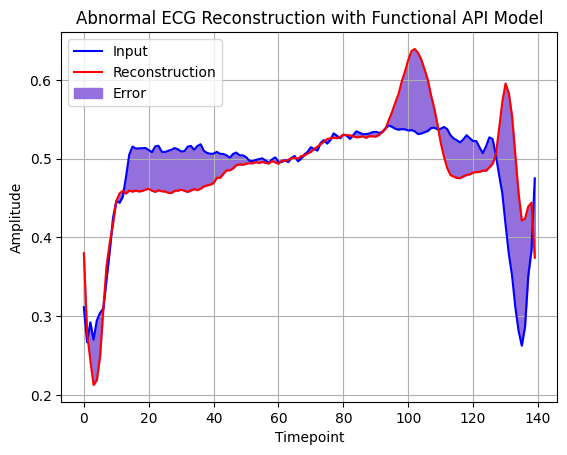

In [14]:
plot(abn_test_API, 0, reconstructed, "Abnormal ECG Reconstruction with Functional API Model")

# Keras Model Subclassing
**Sequential API** = like simple end-to-end pipeline with only 1 channel; it cannot manage multiple inputs/outputs. 

The following uses the Sequential API, but subclassing allows manual passing bw encoder + decoder layers, affording better control. This method requires writing logic of the class.\
Sequential Documentation: https://keras.io/guides/sequential_model/

In [15]:
class Autoencoder(Model): # using Keras Model class as template
    def __init__(self): # instantiation 
        super(Autoencoder, self).__init__() # calls Model's instantiation
        self.encoder = tf.keras.Sequential([
            # layering to compress fetaures to 32 -> 16 -> 8
            layers.Dense(32, activation='relu'), 
            # relu = Rectified Linear Unit; converts negatives to 0; improves training clarity + speed  
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu')
        ])
            # layering to reconstruct; final layer has same # of features as input
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(32, activation='relu'),
            # started w 140 features -> final layer 140 
            layers.Dense(140, activation='sigmoid') 
            # output as Sigmoid [0,1] 

        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

decoder output activation=:
- sigmoid [0 1] (0-1 normalised data)
- tanh [-1 1]
- NA for linear output/any range output  (standardised data)


In [16]:
# instantiate/compile, fit 
autoencoder=Autoencoder()
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.fit(norm_train, norm_train, # compare against itself 
                epochs=20, # iterations
                batch_size=512, validation_data=(norm_test, norm_test))

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0465 - val_loss: 0.0452
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0444 - val_loss: 0.0432
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0423 - val_loss: 0.0408
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0399 - val_loss: 0.0382
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0372 - val_loss: 0.0354
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0346 - val_loss: 0.0329
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0321 - val_loss: 0.0305
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0298 - val_loss: 0.0283
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0279 - val_loss: 0.0266
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0264 - val_loss: 0.0253
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0252 - val_loss: 0.0243
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0242 - val_loss: 0.0234
E

#### VIsualisation

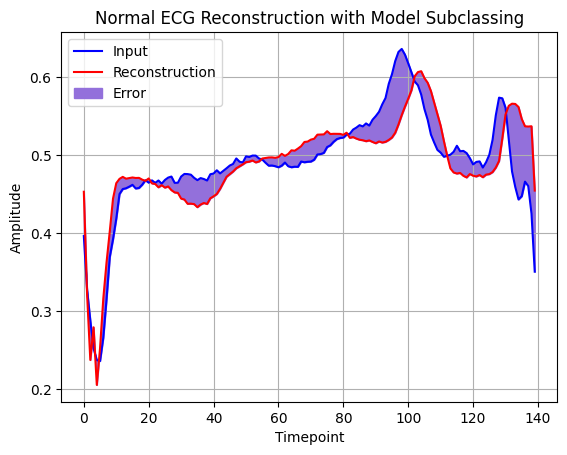

In [17]:
# define fucntion to plot original ECG & reconstructed ECG w error
def plot(data, n, fig_title):
    encoded_img = autoencoder.encoder(data)
    decoded_img = autoencoder.decoder(encoded_img)
    # original data in blue line
    plt.plot(data[n], 'b') 
    # decoded image in red line
    plt.plot(decoded_img[n], 'r')
    # recondstruction error as bw-line fill 
    plt.fill_between(np.arange(140), data[n], decoded_img[n], color='mediumpurple')
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.xlabel('Timepoint')
    plt.ylabel('Amplitude')
    plt.title(fig_title)
    plt.grid()
    plt.show()


plot(norm_test, 0, 'Normal ECG Reconstruction with Model Subclassing')

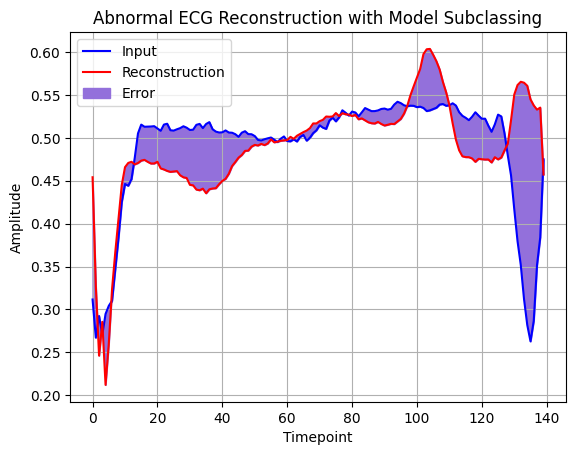

In [18]:
plot(abn_test, 0, 'Abnormal ECG Reconstruction with Model Subclassing')

## Setting Reconstruction Error Threshold for Label Designation

We will calculate threshold to be 1 standard deviation from the mean. If the reconstruction error is greater than this threshold, that ECG will be labeled as having an anomaly. 

1. determine model's threshold (1 std from mean)
2. compare reconstruction error on normal data to threshold
3. compare reconstruction error on abnormal data to threshold

### **Functional API autoencoder's performance:**

In [19]:
def prediction(model, data, threshold):
    reconstruct = model(data)
    loss=losses.mae(reconstruct, data)
    # is the loss of this ECG less than the 1std threshold?
    return tf.math.less(loss, threshold)
    

In [20]:
reconstructed_API = autoencoder_API(norm_train_API)
# calculate losses by mae metric when comparing reconstructed to input
train_loss = losses.mae(reconstructed_API, norm_train_API)
# will use 1 std from mean as threshold
thresh_API = np.mean(train_loss) + np.std(train_loss)

print("Functional API RE threshold:", thresh_API)

Functional API RE threshold: tf.Tensor(0.01859220232367995, shape=(), dtype=float64)


In [29]:
pred = pd.DataFrame(prediction(autoencoder_API, norm_test_API, thresh_API)) 
# returns df of T normal F abnormal for each patient
abn_pred = pd.DataFrame(prediction(autoencoder_API, abn_test_API, thresh_API))

# F == abnormal label, so use ~ as in 'not' to indicate sum(~True) == sum(False)
TN_rate=sum(~abn_pred[0])/len(abn_pred[0])
# precision = TP / TP + FP
precision=sum(pred[0])/(sum(pred[0])+sum(abn_pred[0]))
# recall = TP / TP+FN
recall=sum(pred[0])/len(pred[0])

print("Functional API autoencoder's Precision:", round(precision, 3), "Recall:", round(recall, 3), "True Negative Rate:", round(TN_rate, 3))

Functional API autoencoder's Precision: 1.0 Recall: 0.924 True Negative Rate: 1.0


### **Model Subclass autoencoder's performance:**

In [25]:
reconstructed_sub = autoencoder(norm_train)
# calculate losses by mae metric when comparing reconstructed to input
train_loss = losses.mae(reconstructed_sub, norm_train)
# will use 1 std from mean as threshold
thresh_sub = np.mean(train_loss) + np.std(train_loss)

print("Model Subclassing RE threshold:", thresh_sub)
print('Difference between thresholds:', thresh_sub*2-thresh_API*2)

Model Subclassing RE threshold: tf.Tensor(0.03115501695654125, shape=(), dtype=float64)
Difference between thresholds: tf.Tensor(0.0251256292657226, shape=(), dtype=float64)


In [28]:
pred = pd.DataFrame(prediction(autoencoder, norm_test, thresh_sub))
abn_pred = pd.DataFrame(prediction(autoencoder, abn_test, thresh_sub))

# F == abnormal label, so use ~ as in 'not' to indicate sum(~True) == sum(False)
TN_rate=sum(~abn_pred[0])/len(abn_pred[0])
# precision = TP / TP + FP
precision=sum(pred[0])/(sum(pred[0])+sum(abn_pred[0]))
# recall = TP / TP+FN
recall=sum(pred[0])/len(pred[0])

print("Model Subclassing autoencoder's Precision:", round(precision, 3), "Recall:", round(recall, 3), "True Negative Rate:", round(TN_rate, 3))

Model Subclassing autoencoder's Precision: 0.987 Recall: 0.91 True Negative Rate: 0.983


### Results of Threshold-Based Labelling 
Both models have a nearly identical precision, recall, and true negative rate performances. The Model Subclass autoencoder affords a greater threshold range by a total of 0.0251, suggesting it could be more robust when generalised. The results support a threshold of 1 standard deviation from the mean as being appropriate. Either autoencoder could be used comfortably for encoding normal and anomolous ECG data. 